### Exploring the toplogical relationship of embeded microbes

In `MEGMA`, the micribes are embedded into 2D based on their correlation distance using the manifold learning approaches. In this section, let's explore the toplogical relationship between the microbes. We can first show the optimized topological weighted graph in 2D based on their correlations, then we show how the linear assignment algrithm to assign the microbes into the reglar grid to form the feature maps.



In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import numpy as np

from scipy.spatial.distance import cdist, squareform
from scipy.stats import entropy, truncnorm
import networkx as nx
import markov_clustering as mc

from aggmap import loadmap

In [31]:
url = 'https://raw.githubusercontent.com/shenwanxiang/bidd-aggmap/master/docs/source/_example_MEGMA/dataset/'
countries = ['CHN', 'AUS', 'DEU', 'FRA', 'USA']

all_dfx = []
for country in countries:
    dfx_vector = pd.read_csv(url + '%s_dfx.csv' % country, index_col='Sample_ID')
    all_dfx.append(dfx_vector)
dfx_all = pd.concat(all_dfx, axis=0)
dfx_all = np.log(dfx_all + 1e-8)

In [2]:
megma_all = loadmap('./megma.all')
megma_all.df_scatter.y = -megma_all.df_scatter.y
megma_all.df_embedding.y = -megma_all.df_embedding.y

In [348]:
megma_all.plot_scatter(radius=5)

2022-08-11 20:16:10,026 - INFO - [bidd-aggmap] - generate file: ./feature points_849_correlation_umap_scatter
2022-08-11 20:16:10,035 - INFO - [bidd-aggmap] - save html file to ./feature points_849_correlation_umap_scatter


In [349]:
megma_all.plot_grid()

2022-08-11 20:16:13,254 - INFO - [bidd-aggmap] - generate file: ./feature points_849_correlation_umap_mp
2022-08-11 20:16:13,263 - INFO - [bidd-aggmap] - save html file to ./feature points_849_correlation_umap_mp


### Plotting the linear assignment of the embedded microbes

In [352]:
def plot_assignment(df_embedding, figsize = (10, 9)):
    
    df_sub2 = df_embedding.copy()
    grid = megma_all.df_grid_reshape.set_index('v')[['x', 'y']]
    grid.columns=['g_x', 'g_y']
    dfs = df_sub2.join(grid)

    w = dfs.g_x.max() + 1
    h = dfs.g_y.max() + 1

    my_grid = np.dstack(np.meshgrid(np.linspace(dfs.min().x, dfs.max().x, w), np.linspace(dfs.max().y, dfs.min().y, h))).reshape(-1,2)
    my_grid_index = np.dstack(np.meshgrid(np.linspace(0, w-1, w), np.linspace(0, h-1, h))).reshape(-1,2)

    dfg = pd.DataFrame(my_grid, columns=['t_x', 't_y'], )
    dfi = pd.DataFrame(my_grid_index.astype(int), columns=['g_x', 'g_y'])

    dfn = dfg.join(dfi).set_index(['g_x', 'g_y'])

    dfs = dfs.sort_values(['g_y', 'g_x']).set_index(['g_x','g_y'])
    dfs = dfs.join(dfn)

    fig, ax = plt.subplots(figsize = figsize)

    for i in range(len(dfs)):
        ts = dfs.iloc[i]
        ax.arrow(ts.x, ts.y, ts.t_x-ts.x, ts.t_y-ts.y, 
                 color = ts.colors, head_width = 0.08,  head_length=0.1, overhang = 0.5, lw=1)

    # nx.draw_networkx(g, pos=sub_pos, node_size = 200, labels=labeldict, with_labels = False, edgecolors = 'grey',
    #                  edge_color = 'gray', alpha = 1, width = 0.09, node_color= subgraph_colors)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.bottom.set_visible(False)
    fig.tight_layout()
    return fig

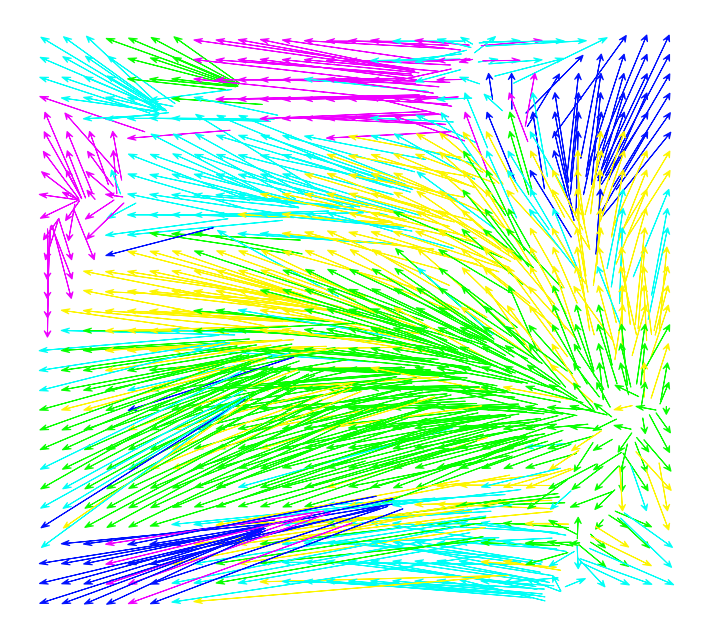

In [353]:
fig = plot_assignment(megma_all.df_embedding)

<AxesSubplot:>

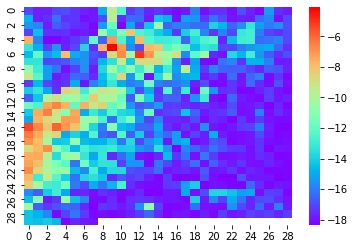

In [4]:
df = pd.DataFrame(index=megma_all.feature_names_reshape)
tm = df.join(megma_all.info_scale['mean']).values.reshape(*megma_all.fmap_shape)
sns.heatmap(tm, cmap = 'rainbow')

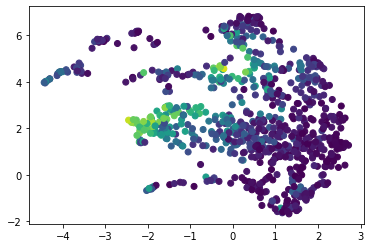

In [5]:
p = megma_all.df_scatter.set_index('IDs').join(megma_all.info_scale['mean'])
plt.scatter(p.x, p.y, c = p['mean'])

### Fetching the optimized toplogical graph

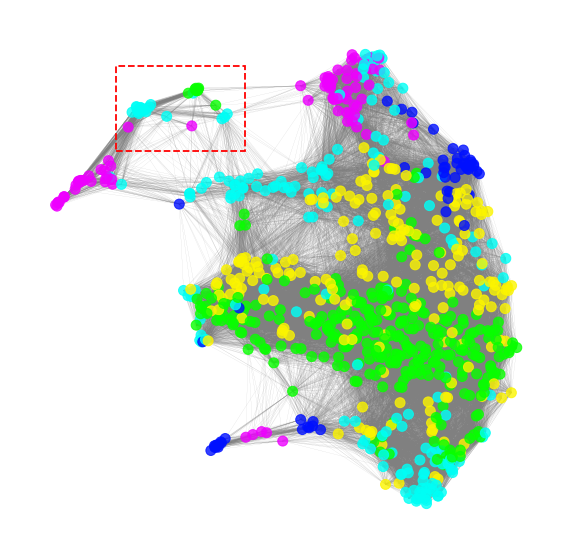

In [341]:
def get_graph_v(embd):
    '''
    Get the graph in low dimension
    '''
    distances = cdist(embd.embedding_, embd.embedding_)
    a = embd._a
    b = embd._b
    ## acorrding to UMAP defined low-D graph 
    graph_v = 1.0 / (1.0 + a * distances ** (2 * b))       
    return graph_v


gv = get_graph_v(megma_all.embedded)
#np.fill_diagonal(gv,0)
A = gv*(gv > 0.2)
np.fill_diagonal(A, 0.)
G = nx.from_numpy_matrix(np.matrix(A))

# layout = nx.spring_layout(G, iterations = 900)

dfs = megma_all.df_embedding

positions = dfs.reset_index()[['x', 'y']]
pos = {}
for i in range(len(positions)):
    pos.update({i:positions.iloc[i].values})
    
fig, ax = plt.subplots(figsize = (10, 10))
nx.draw(G, pos=pos, ax = ax, node_size = 100, edge_color = 'gray', #edgecolors = 'grey', 
        alpha = 0.8, width = 0.09, node_color= dfs.colors)
#nx.draw_networkx_edge_labels(G, pos=layout)
rect = patches.Rectangle((-3.5, 5), 2, 1.6, linewidth=1.8, ls = '--', edgecolor='r', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

### Markov clustring on the graph

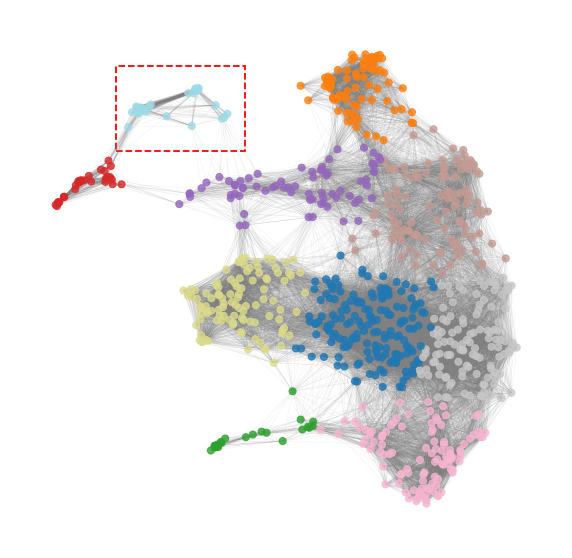

In [89]:
matrix = nx.to_scipy_sparse_matrix(G)
result = mc.run_mcl(matrix)           # run MCL with default parameters
clusters = mc.get_clusters(result)    # get clusters
cluster_map = {node: i for i, cluster in enumerate(clusters) for node in cluster}
colors = [cluster_map[i] for i in range(len(G.nodes()))]

fig, ax = plt.subplots(figsize = (10, 10))

rect = patches.Rectangle((-3.5, 5), 2, 1.6, linewidth=1.8, ls = '--', edgecolor='r', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

nx.draw(G, pos=pos, ax = ax, node_size = 50, edge_color = 'gray', 
        alpha = 0.8, width = 0.07, node_color= colors, cmap = 'tab20')

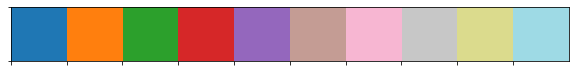

In [288]:
import cmasher as cmr
l = pd.Series(colors).value_counts().sort_index()
colors_ = cmr.take_cmap_colors('tab20', len(l), return_fmt='hex')
sns.palplot(colors_)

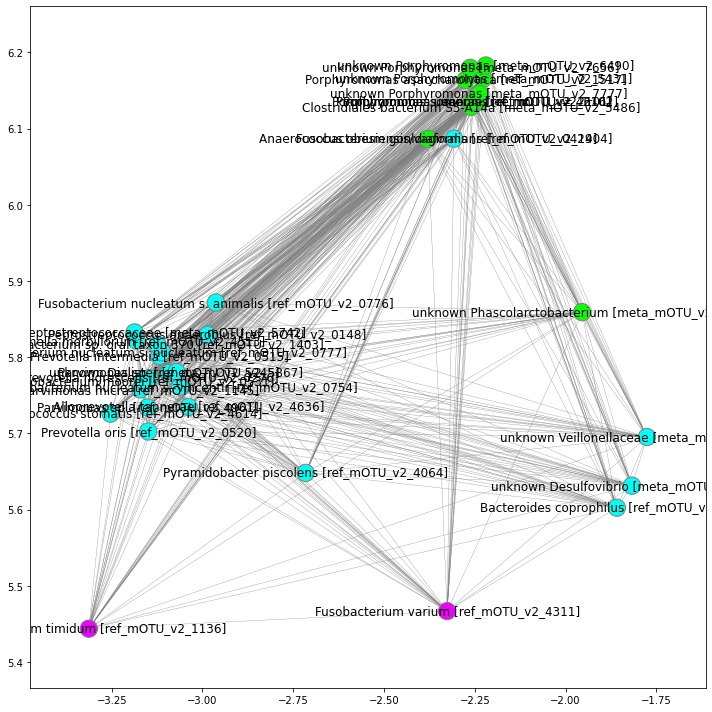

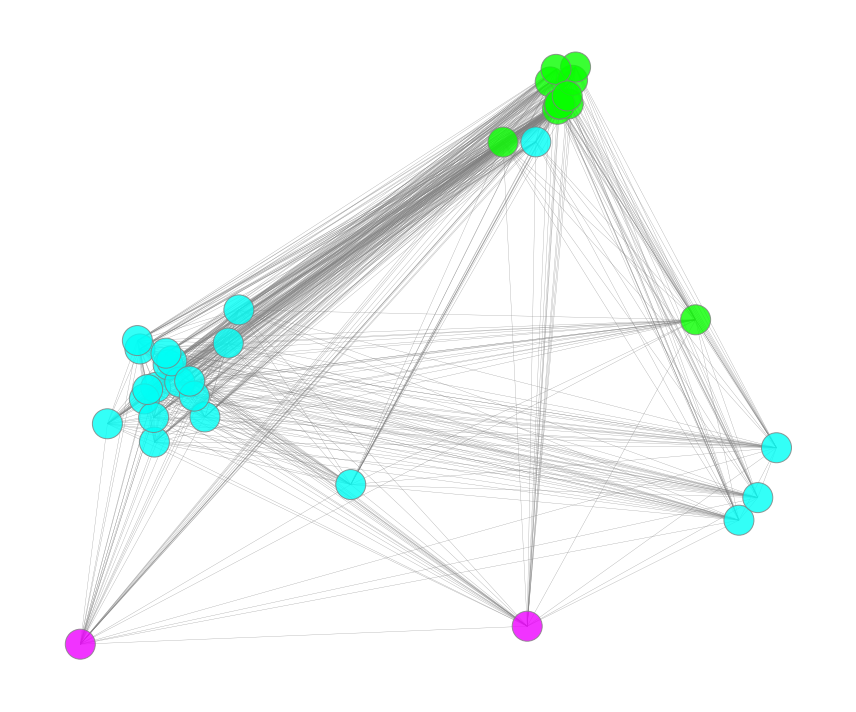

In [340]:
i = 9 ## selected cluster

important_nodes = pd.Series(colors)[pd.Series(colors)==i].index.to_list()
df_sub = dfs[(pd.Series(colors)== i).values]
sub_positions = positions[(pd.Series(colors)==i).values]
sub_pos = {}
for i in range(len(sub_positions)):
    ts = sub_positions.iloc[i]
    sub_pos.update({ts.name:ts.values})
    

g = G.subgraph(important_nodes)
subgraph_colors = df_sub.set_index('idx').loc[list(g.nodes)].colors


#df_sub.index = df_sub.index.map(lambda x:x.split(' [')[0])
# df_sub = df_sub[~df_sub.index.duplicated(keep='first')]
labeldict = df_sub.reset_index().set_index('idx')['index'].to_dict()


fig, ax = plt.subplots(figsize = (10, 10))
nx.draw_networkx(g, pos=sub_pos, node_size = 300, labels=labeldict, with_labels = True, edgecolors = 'grey',
                 edge_color = 'gray', alpha = 1, width = 0.3, node_color= subgraph_colors)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
fig.tight_layout()

fig, ax = plt.subplots(figsize = (12, 10))
nx.draw_networkx(g, pos=sub_pos, node_size = 900, labels=labeldict, with_labels = False, edgecolors = 'grey',
                 edge_color = 'gray', alpha = 0.8, width = 0.3, node_color= subgraph_colors)

ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)
fig.tight_layout()

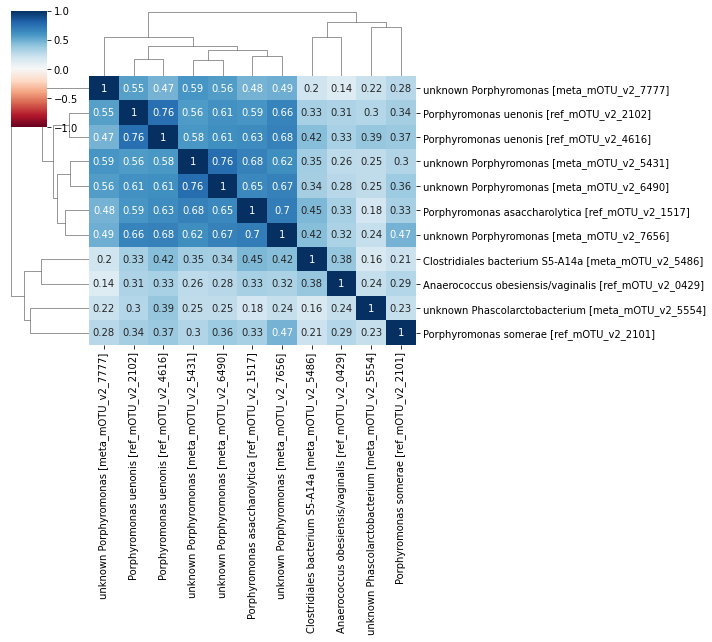

In [93]:
l1 = df_sub[df_sub.Channels == 'cluster_02']
corr_matrix = dfx_all.corr().loc[l1.index][l1.index]
sns.clustermap(corr_matrix, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 10}, vmin=-1, vmax=1, figsize=(10,9))

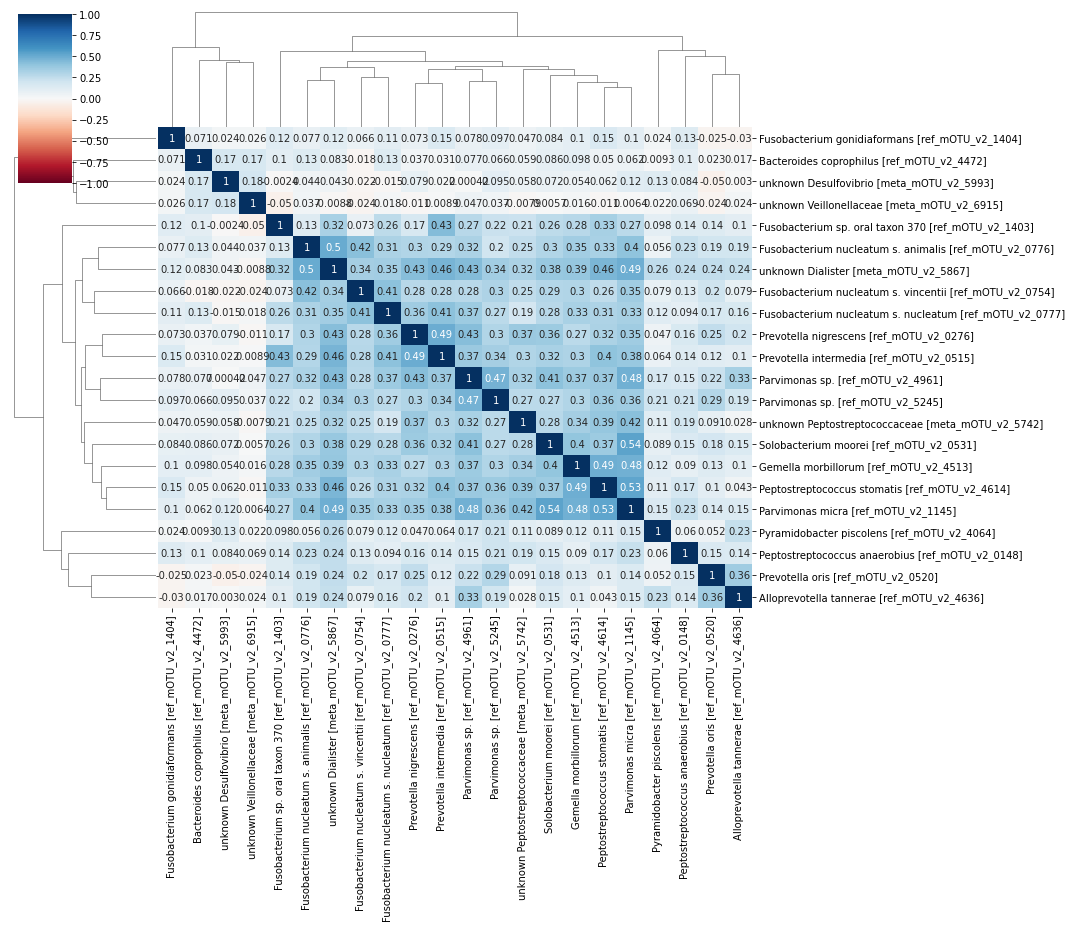

In [94]:
l2 = df_sub[df_sub.Channels == 'cluster_03']
corr_matrix = dfx_all.corr().loc[l2.index][l2.index]

sns.clustermap(corr_matrix, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 10}, vmin=-1, vmax=1, figsize=(15,13))

In [354]:
megma_all.to_nwk_tree()

/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/aggmap-1.1.5-py3.7.egg/aggmap/utils/gen_nwk.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TYPE'] = 'clade'
/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/aggmap-1.1.5-py3.7.egg/aggmap/utils/gen_nwk.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['STYLE'] = 'normal'


,TYPE,colors,STYLE
Clostridium saccharogumia [ref_mOTU_v2_0473],clade,#08ff00,normal
Clostridium innocuum [ref_mOTU_v2_0643],clade,#ee00ff,normal
Clostridium sp. KLE 1755 [ref_mOTU_v2_0860],clade,#ee00ff,normal
Clostridium scindens [ref_mOTU_v2_0883],clade,#ee00ff,normal
Clostridium boltae/clostridioforme [ref_mOTU_v2_0886],clade,#ee00ff,normal
...,...,...,...
Veillonella atypica [ref_mOTU_v2_0561],clade,#ee00ff,normal
Veillonella dispar [ref_mOTU_v2_4469],clade,#ee00ff,normal
Veillonella parvula [ref_mOTU_v2_1042],clade,#ee00ff,normal
Veillonella sp. [ref_mOTU_v2_5068],clade,#ee00ff,normal
